In [1]:
import numpy as np
from mne.decoding import CSP
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import os
import textwrap
import warnings
import numpy as np

In [2]:
'''
EEGdata provides easy access to neurophysiological recordings, with
brain-computer interface (BCI) research in mind. In short, a BCI is
like speech recognition, but for brain signals.

The aim is to make publicly available datasets available to
researchers by automatically downloading and parsing them, and provide
the data in a no-frills format.
'''


CACHE_VAR = 'EEGTOOLS_DATA_CACHE'
CACHE_PATH = '~/eegtools_data'


class Recording:
  '''
  Recording is the format in which eegtools.data delivers the imported
  datasets. It's main ingredient is the matrix X that holds the
  recording, and an event matrix that annotates the samples in X.
  '''
  def __init__(self, X=None, dt=None, chan_lab=[], events=[], folds=None,
    event_lab=[], rec_id='', license=''):
    '''
    Initializes the recording.

    Parameters
    ----------
    X : array of shape (p, n)
      Contains the n samples for p sensors.

    dt : array of shape (n - 1)
      Describes the difference in time between consecutive samples of
      X. Both continuous and interrupted sessions can be stored this
      way. If the temporal difference is unknown, NaN can be used to
      indicate this difference.

    chan_lab : list with p strings
      Contains a label for each sensor. For EEG sensors, preferably
      labels from the (extended) 10-20 system are used.

    events : array of shape (>= 3, m)
      Describes m events. The rows of events contain respectively the
      event id, the start and the end of event as zero-based indices
      matching X. An optional extra rows can be used for additional
      values (e.g. for user reported emotional ratings, pressure on a
      switch etc.)

    folds : array of length m
      Contains a value for each event, describing a grouping of
      events. These groups can be used for cross-validation.

    event_lab : dictionary
      Is a lookup table that assigns a textual meaning to event ids.
      The values of the dictionary describe tag-like properties of the
      event.

    rec_id : string
      Is a string that identifies both the experiment and the subject.

    license: string
      The license under which the data is made available.
    '''
    self.X = np.atleast_2d(X).astype(np.float32)
    self.dt = dt = np.atleast_1d(dt)
    self.chan_lab = chan_lab
    self.events = events = np.atleast_2d(events)
    self.folds = folds = np.atleast_1d(folds).astype(int)
    self.event_lab = event_lab = dict(event_lab)
    self.rec_id = rec_id
    self.license = license

    if not self.rec_id:
      warnings.warn('No identifier (rec_id) provided for recording.')
    if not self.license:
      warnings.warn('No license provided for recording.')

    assert self.X.ndim == 2  # sensors x time
    p, n = self.X.shape
    assert len(self.chan_lab) == p
    assert self.dt.size == n - 1, \
      'Temporal difference dt has shape %s, should be %s' % \
        (self.dt.shape, (n - 1,))
    
    # check for matching events
    event_ids = set(np.unique(self.events[0]))
    event_lab_ids = set(self.event_lab.keys())
    assert len(event_ids.difference(event_lab_ids)) == 0, \
      'Unique events %s do not match events in event_lab %s!' % \
        (list(event_ids), list(event_lab_ids))

    # check event conventions
    ids, starts, ends = events[0], events[1], events[2]
    duration = ends - starts
    assert np.all(duration >= 0), \
      'Events should have a non-negative duration.'
    assert np.all(starts >= 0), \
      'Event starts before data stream X starts.'
    assert np.all(ends <= X.shape[1]), \
      'Events continue after data stream X ended.'
    assert np.all(np.diff(starts) >= 0), \
      'The starts of the events should be sorted chronologically.'

    # check folds
    assert folds.size == events.shape[1], 'Expected a fold number per event.'


  @property
  def sample_rate(self):
    '''Estimate sample rate based on dt.'''
    dt = self.dt 
    return 1./np.median(dt[np.isfinite(dt)])


  @property
  def continuous_starts(self):
    '''Return indices of starts of new continuous blocks'''
    return np.hstack([[0], 1 + np.flatnonzero(self.dt != 1./self.sample_rate)])

  
  def __str__(self):
    return ('Recording "%(rid)s" (%(p)d channels x %(n)d samples) '
      'at %(fs).2f Hz in %(blocks)d continuous blocks, '
      'with %(nevents)d events in %(nevent_types)d classes.') % \
      dict(p=self.X.shape[0], n=self.X.shape[1], fs=self.sample_rate,
        nevents=self.events.shape[1], nevent_types=len(self.event_lab), 
        blocks=self.continuous_starts.size, rid=self.rec_id)


def print_story(events, sample_rate):
  '''Not fully complete helper function to describe the story of the events.
  '''
  dic = dict(EVENTS)
  for (ei, start, end, optional) in events.T:
    print( '%s @ %.2fs (%.2fs long) -> %d.' % (
      dic[ei].ljust(30), 
      start / sample_rate, 
      (end - start) / sample_rate, 
      optional
      ))


def data_source():
  return np.DataSource(make_cache_path(get_cache_path()))


def get_cache_path():
  '''Get path for caching downloaded files. The location is indicated
  by the EEGTOOLS_DATA_CACHE environment variable. When the path does not
  exist, it is created and a README.txt with instructions is written
  to this location.

  Returns a string containing the path.
  '''
  return os.environ.get(CACHE_VAR, os.path.expanduser(CACHE_PATH))


def make_cache_path(path):
  '''Create path for caching downloaded files. When the path does not
  exist it is created, and a README.txt with instructions is written
  to this location.

  Returns a string containing the path.
  '''
  if not os.path.exists(path):
    os.makedirs(path)

  readme = os.path.join(path, 'README.txt')
  if not os.path.exists(readme):
    with open(readme, 'w') as f:
      f.write(textwrap.dedent(
        '''\
        This directory was created by eegtools to cache downloaded BCI
        datasets. It is safe to remove the cached files in this
        directory, but doing so will result in a performance penalty.

        To change this path, set the %(env)s environment variable with
        the path of your preference. For example:
        
            $ export %(env)s=%(cache_path)s

        That is all.
        ''' % dict(env=CACHE_VAR, cache_path=CACHE_PATH)))

  return path

In [3]:
#!/usr/bin/env python
import argparse, os.path
import numpy as np
from scipy import io
# from shared import Recording, data_source

__all__ = ['load', 'subjects', 'sessions']

sessions = [i for i in range(12) if i not in [3, 8]]
subjects = sessions  # Legacy name, since sessions is more accurate.

URL_TEMPLATE = 'https://s3-eu-west-1.amazonaws.com/bcidata.breuderink/'\
  'reuderink_affpac/reuderink_affpac_s%d.mat.gz'

LICENSE = '''Please cite:

[1] Boris Reuderink, Mannes Poel, and Anton Nijholt. The impact of loss of
    control on movement BCIs. IEEE Transactions on Neural Systems and
    Rehabilitation Engineering, 19(6):628-637, December 2011. doi:
    10.1109/TNSRE.2011.2166562.

[2] Boris Reuderink, Anton Nijholt, and Mannes Poel. Affective Pacman: A
    frustrating game for brain-computer interface experiments. In Proceedings
    of the 3rd International Conference on Intelligent Technologies for Inter-
    active Entertainment (INTETAIN 2009), volume 9 of Lecture Notes of the
    Institute for Computer Sciences, Social Informatics and Telecommunications
    Engineering, pages 221-227. May 2009. doi: 10.1007/978-3-642-02315-6_23.
'''


EVENTS = [
  (1, 'index finger left hand key press'),
  (2, 'index finger right hand key press'),
  (3, 'index finger left hand key press error'),
  (4, 'index finger right hand key press error'),
  (5, 'visual screen freeze error'),
  (10, 'init_level'),
  (11, 'next_level'),
  (12, 'pacman avatar died'),
  (20, 'start_game'),
  (21, 'end_game'),
  (22, 'start_normal'),
  (23, 'end_normal'),
  (24, 'start_frustration'),
  (25, 'end_frustration'),
  (26, 'start_sam'),
  (27, 'end_sam'),
  (28, 'start_pause'),
  (29, 'end_pause'),
  (90, 'keyboard error loss-of-control'),
  (100, 'valence'),
  (110, 'arousal'),
  (120, 'dominance'),
  ]

EVENT_OFFSETS = [
  (1, [0, 0]),
  (2, [0, 0]),
  (3, [0, 0]),
  (4, [0, 0]),
  (5, [0, 0]),
  (11, [0, 0]),
  (12, [0, 0]),
  ]

# Events with an extra value are stored separately:
COL_TO_EVENT = [(2, 90), (3, 100), (4, 110), (5, 120)]


def status_to_events(status, fs):
  events = []
  for marker, interval in EVENT_OFFSETS:
    offset = (fs * np.array(interval)).astype(int)
    intervals = np.flatnonzero(status==marker) + offset.reshape(-1, 1)
    events.append(
      np.vstack([marker * np.ones((1, intervals.shape[1]), int), intervals]))

  return np.hstack(events)


def block_to_events(I):
  events = []

  blocks = I[1]
  for bi in np.unique(blocks):
    if bi == -1:
      continue
    block_samp = np.flatnonzero(blocks == bi)
    start, end = np.min(block_samp), np.max(block_samp)

    for ci, ei in COL_TO_EVENT:
      events.append((ei, start, end, I[ci, block_samp[0]]))

  events = np.array(events, int).T

  # remove events marking the condition with full control
  events = events[:,~np.logical_and(events[0] == 90, events[3] == 0)]
  events[3, events[0] == 90] = 0
  return events


def load(subject_id, ds=data_source()):
  matfile = ds.open(URL_TEMPLATE % subject_id)
  mat = io.loadmat(matfile, struct_as_record=True)

  X = mat['X'].astype(np.float32)
  dt = np.diff(mat['I'][0])
  chan_lab = [str(l[0]) for l in mat['chann'].flat]

  # create event matrix
  sample_rate = 1./np.median(dt)
  status_events = status_to_events(mat['Y'], sample_rate)
  block_events = block_to_events(mat['I'])
  events = np.hstack([
    np.vstack([status_events, np.zeros((1, status_events.shape[1]), int)]), 
    block_events
    ])
  events = events[:,np.argsort(events[1])]  # sort events on start time

  # fill other attributes
  event_lab = dict(EVENTS)
  folds = mat['I'][1][events[1]].astype(int)  # use block number as fold id

  # construct final record
  return Recording(X=X, dt=dt, chan_lab=chan_lab, events=events, 
    folds=folds, event_lab=event_lab, 
    rec_id='reuderink-affpac-s%d' % subject_id, license=LICENSE)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot some raw EEG epochs
def plot_epochs(X_epochs, fs, num_trials=5):
    fig, axes = plt.subplots(num_trials, 1, figsize=(10, 6))
    for i in range(num_trials):
        axes[i].plot(np.arange(X_epochs.shape[2]) / fs, X_epochs[i][0], label=f'Trial {i+1}')
        axes[i].set_ylabel("Amplitude (µV)")
        axes[i].legend()
    plt.xlabel("Time (s)")
    plt.suptitle("Sample EEG Epochs")
    plt.show()

# 2. Plot CSP features
def plot_csp_features(X_csp, labels):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=X_csp, orient="h")
    plt.xlabel("Feature Value")
    plt.ylabel("CSP Component")
    plt.title("CSP Feature Distributions")
    plt.show()

888
888
Computing rank from data with rank=None
    Using tolerance 7e+05 (2.2e-16 eps * 47 dim * 6.7e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 0


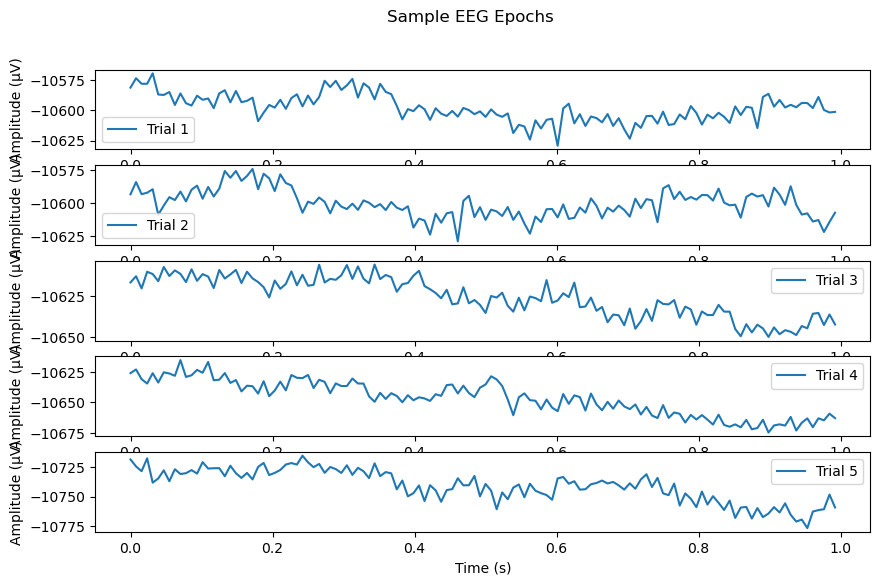

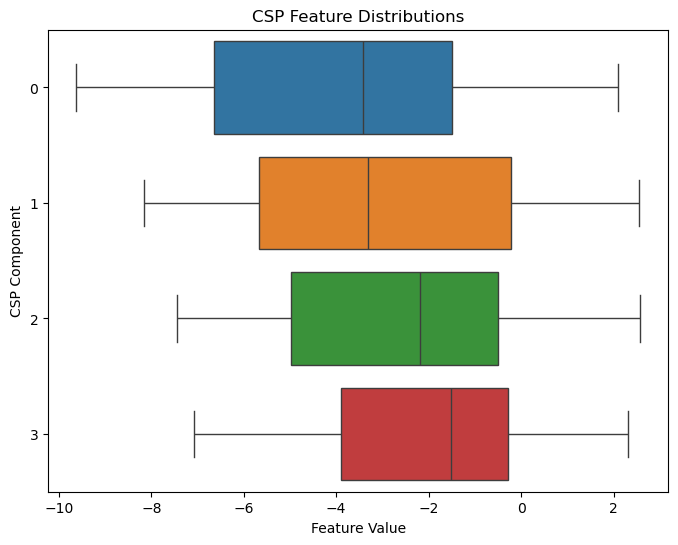

SVM Classification Accuracy per Fold: [0.95495495 0.95495495 0.95495495 0.90540541]
Average Accuracy: 0.9426
949
949
Computing rank from data with rank=None
    Using tolerance 6e+05 (2.2e-16 eps * 47 dim * 5.8e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 1


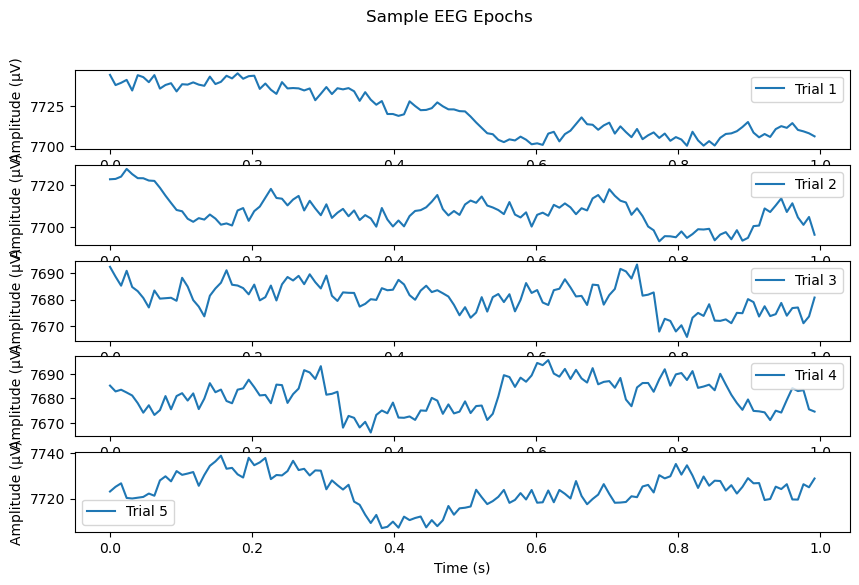

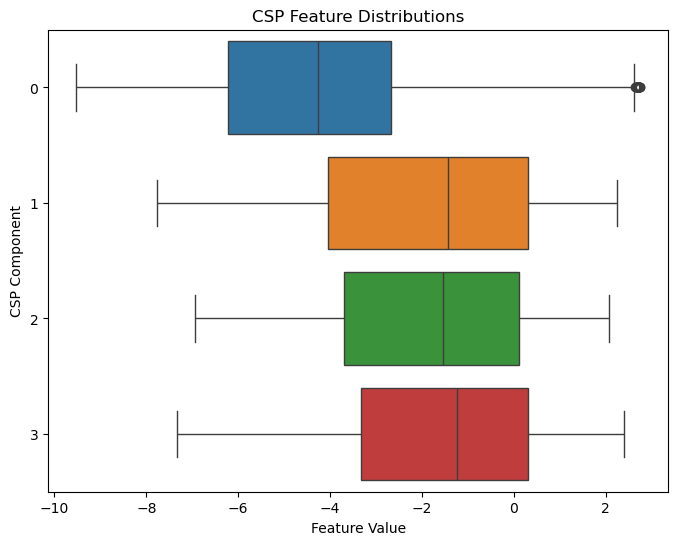

SVM Classification Accuracy per Fold: [0.97058824 0.94936709 0.96624473 0.97046414]
Average Accuracy: 0.9642
823
823
Computing rank from data with rank=None
    Using tolerance 4.4e+05 (2.2e-16 eps * 47 dim * 4.2e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 2


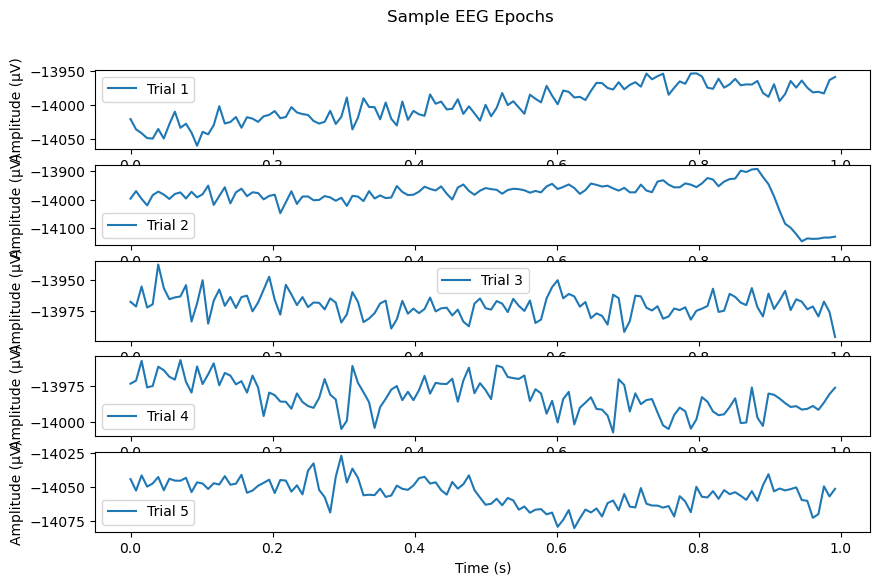

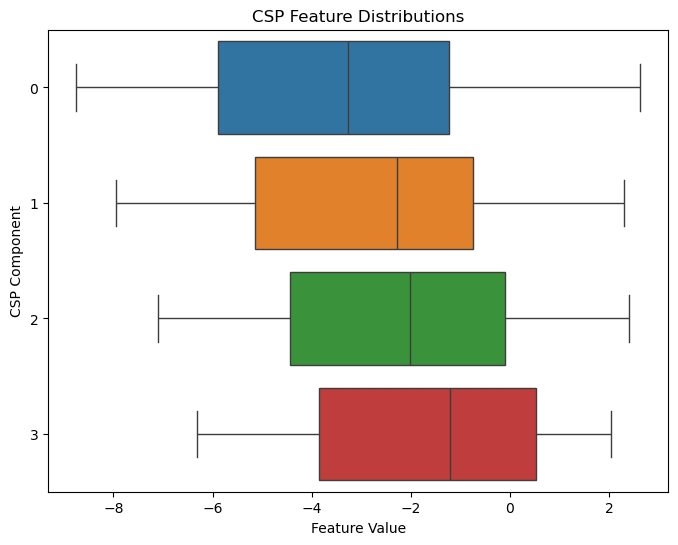

SVM Classification Accuracy per Fold: [0.94174757 0.91262136 0.9368932  0.94634146]
Average Accuracy: 0.9344
931
931
Computing rank from data with rank=None
    Using tolerance 7.6e+05 (2.2e-16 eps * 47 dim * 7.2e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 4


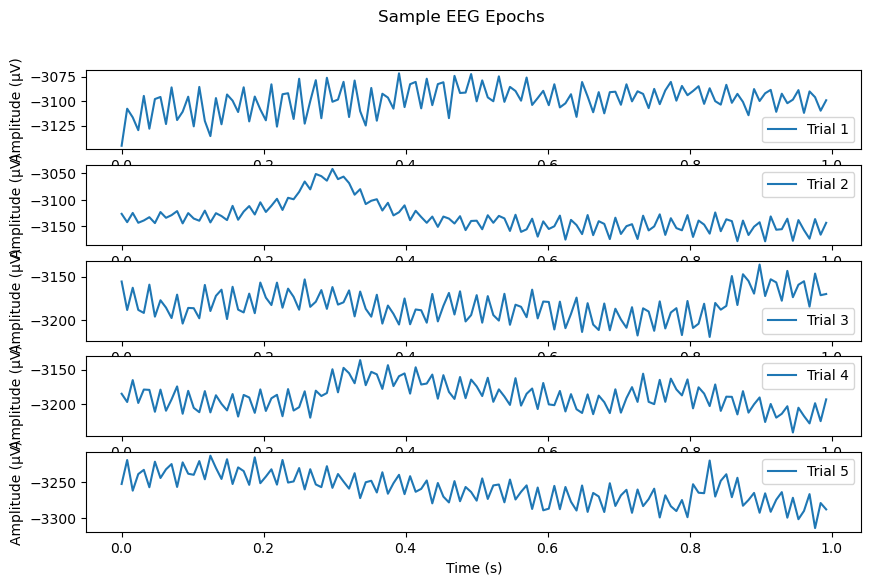

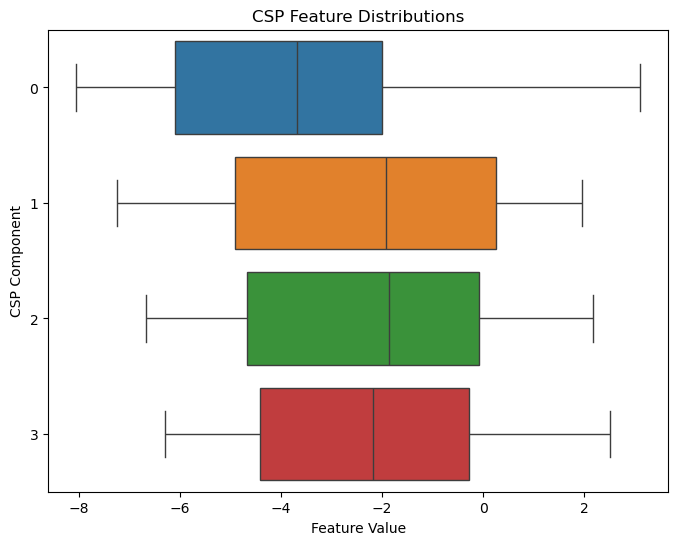

SVM Classification Accuracy per Fold: [0.93991416 0.93991416 0.91416309 0.93965517]
Average Accuracy: 0.9334
925
925
Computing rank from data with rank=None
    Using tolerance 4.1e+05 (2.2e-16 eps * 47 dim * 3.9e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 5


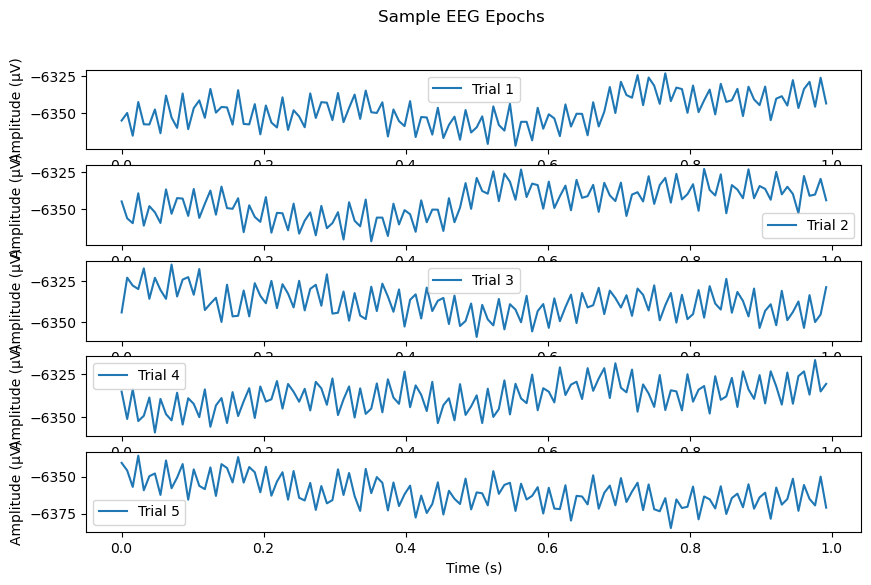

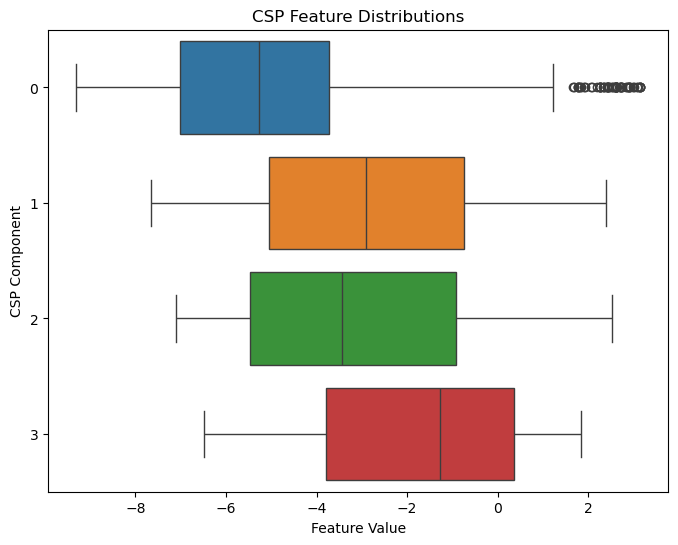

SVM Classification Accuracy per Fold: [0.94827586 0.95238095 0.93073593 0.94805195]
Average Accuracy: 0.9449
1214
1214
Computing rank from data with rank=None
    Using tolerance 5.8e+05 (2.2e-16 eps * 47 dim * 5.6e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 6


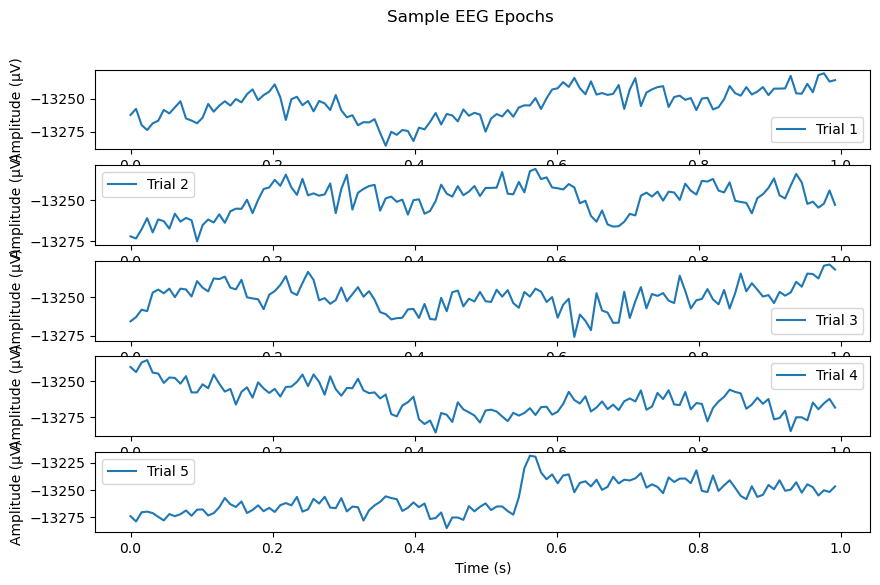

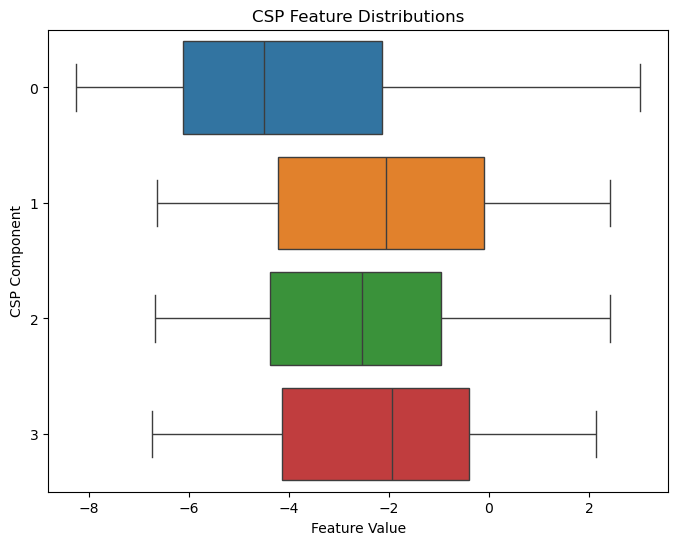

SVM Classification Accuracy per Fold: [0.93421053 0.93421053 0.9339934  0.9339934 ]
Average Accuracy: 0.9341
948
948
Computing rank from data with rank=None
    Using tolerance 5.6e+05 (2.2e-16 eps * 47 dim * 5.4e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 7


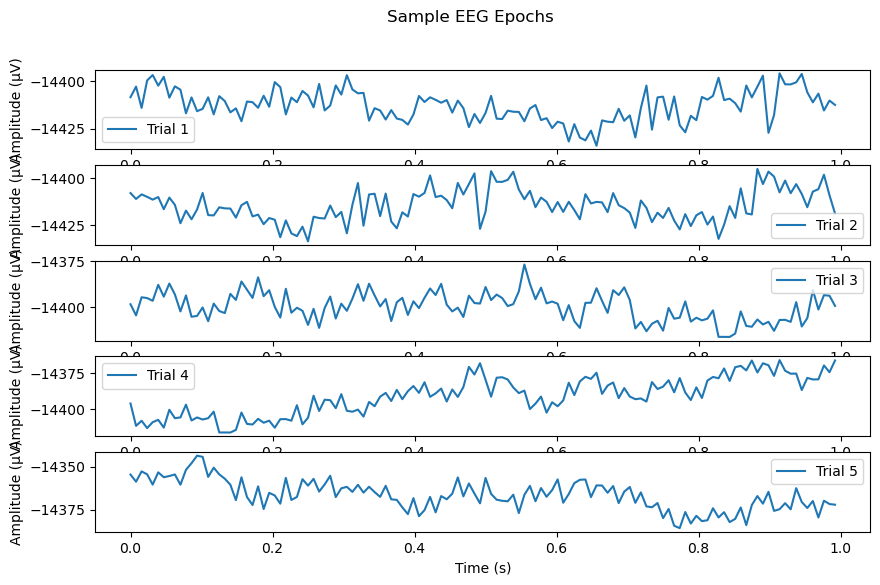

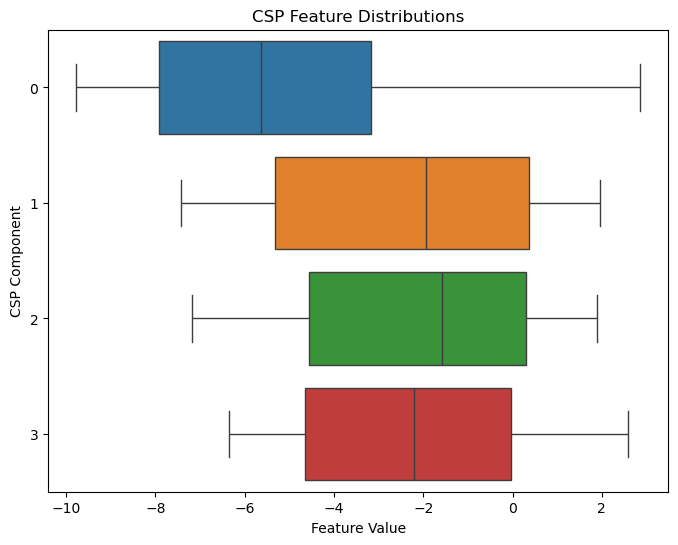

SVM Classification Accuracy per Fold: [0.93670886 0.93248945 0.93248945 0.93248945]
Average Accuracy: 0.9335
882
882
Computing rank from data with rank=None
    Using tolerance 5.2e+05 (2.2e-16 eps * 47 dim * 5e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 9


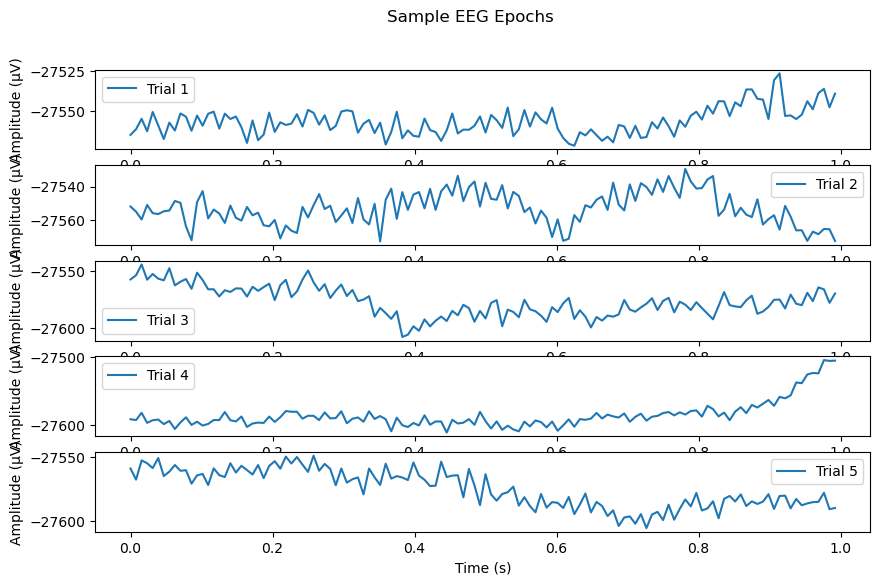

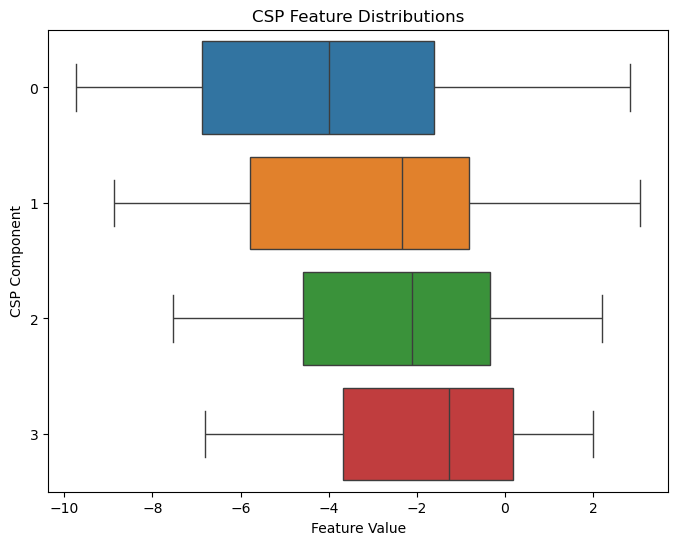

SVM Classification Accuracy per Fold: [0.97285068 0.95022624 0.97727273 0.98636364]
Average Accuracy: 0.9717
1054
1054
Computing rank from data with rank=None
    Using tolerance 5.7e+05 (2.2e-16 eps * 47 dim * 5.5e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 10


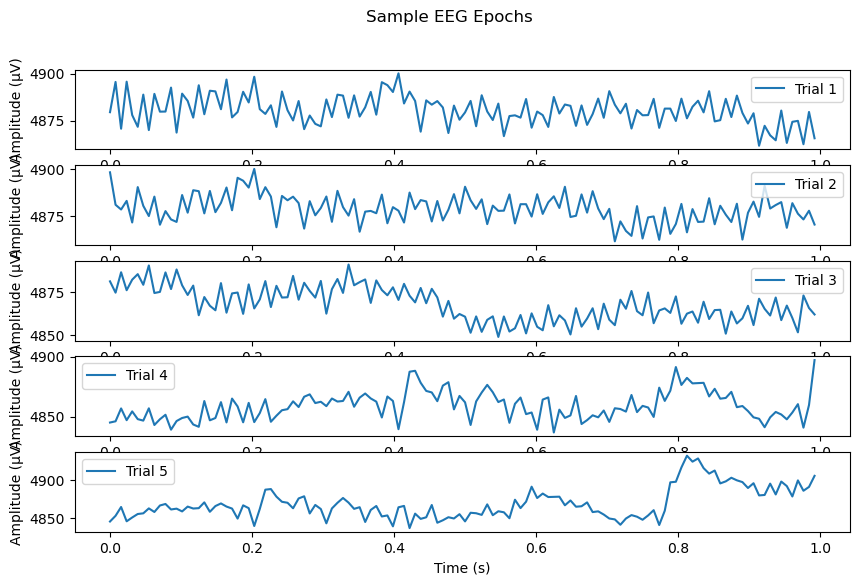

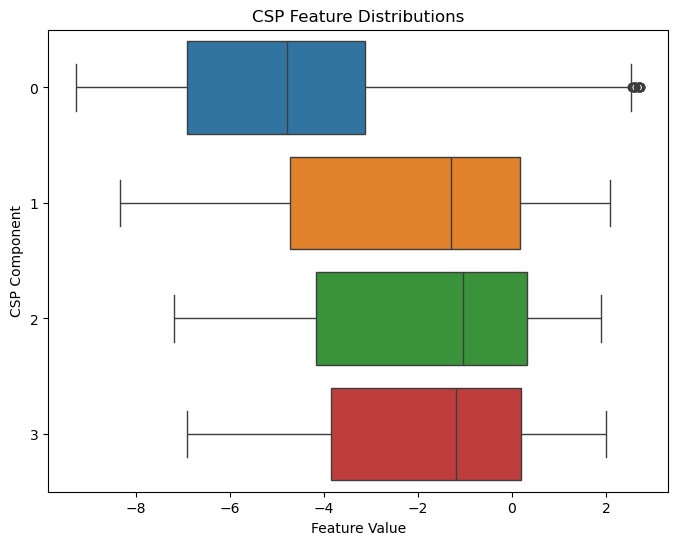

SVM Classification Accuracy per Fold: [0.93939394 0.93939394 0.94296578 0.94296578]
Average Accuracy: 0.9412
981
981
Computing rank from data with rank=None
    Using tolerance 6.8e+05 (2.2e-16 eps * 47 dim * 6.6e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 11


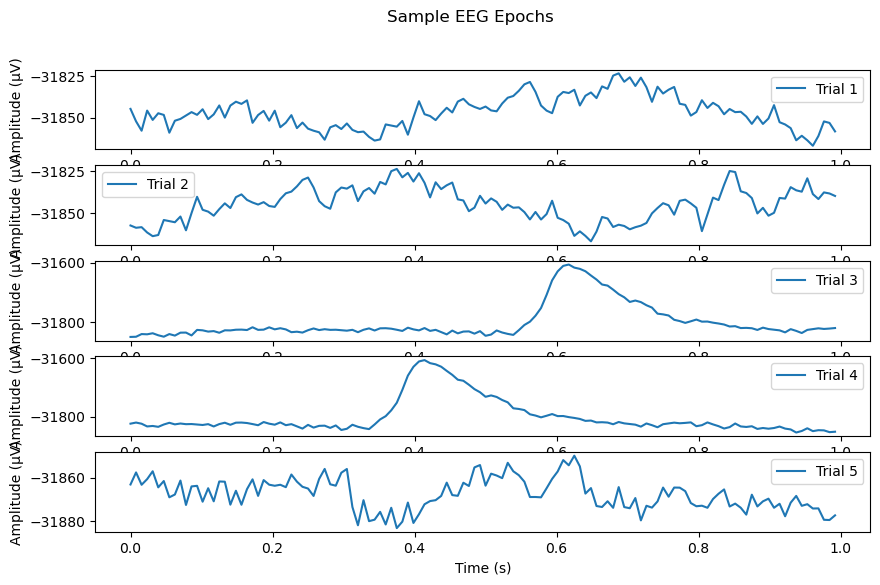

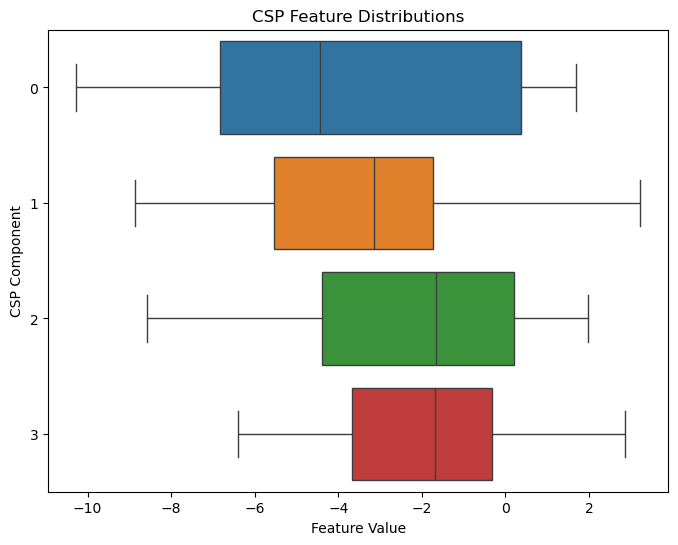

SVM Classification Accuracy per Fold: [0.9796748  0.97142857 0.95918367 0.98367347]
Average Accuracy: 0.9735


In [6]:
# left vs left error

# Parameters
n_filters = 4  # CSP components per class
k = 4  # Number of cross-validation folds

# Load data

for i in range(12): 
    if i in [3, 8]:
        continue
    rec = load(i)

    # Extract EEG data
    X = rec.X
    events = rec.events
    event_lab = rec.event_lab
    fs = int(1.0 / rec.dt[0]) # sampling rate

    left_press = 1
    left_error = 3

    selected_events = events[:, np.isin(events[0], [left_press, left_error])]
    # labels = (selected_events[0] == left_error).astype(int) 

    # Epoch extraction
    window = int(fs * 1)  # 1-second window
    epochs = []
    labels = []
    for event, start_time in selected_events[:2].T:
        start_idx = int(start_time)
        end_idx = start_idx + window
        if end_idx < X.shape[1]:  # Ignore out-of-bounds epochs
            epochs.append(X[:, start_idx:end_idx])
            labels.append(event == left_error)
    
    X_epochs = np.array(epochs)  # Shape: (n_trials, n_channels, n_samples)

    # CSP
    csp = CSP(n_components=n_filters, log=True)
    X_epochs = X_epochs.astype(np.float64)
    print(len(X_epochs))
    print(len(labels))
    X_csp = csp.fit_transform(X_epochs, labels)
    
    # SVM classifier with cross-validation
    svm = SVC(kernel='linear')
    scores = cross_val_score(svm, X_csp, labels, cv=k)
    
    # Output results
    print(f'Subject Number: {i}')
    plot_epochs(X_epochs, fs)
    plot_csp_features(X_csp, labels)
    print(f'SVM Classification Accuracy per Fold: {scores}')
    print(f'Average Accuracy: {np.mean(scores):.4f}')

935
935
Computing rank from data with rank=None
    Using tolerance 7.1e+05 (2.2e-16 eps * 47 dim * 6.8e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 0


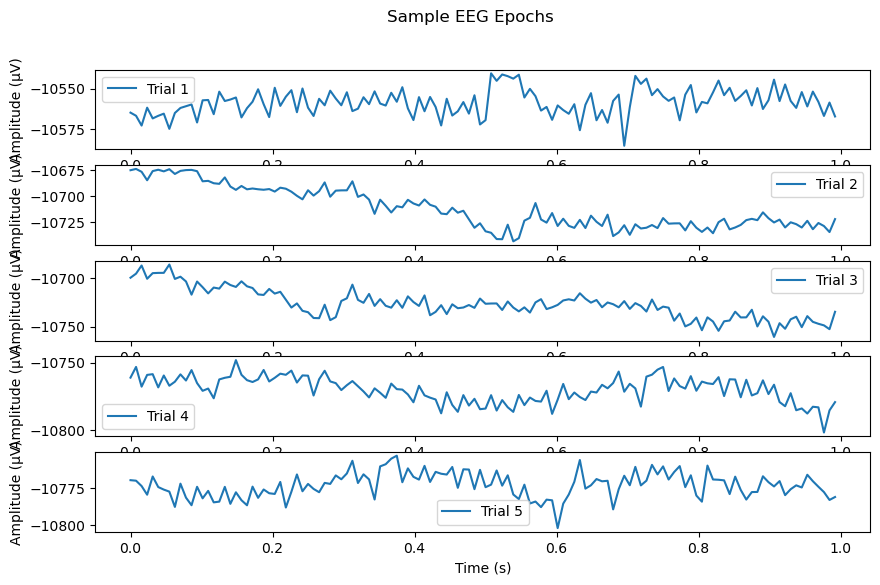

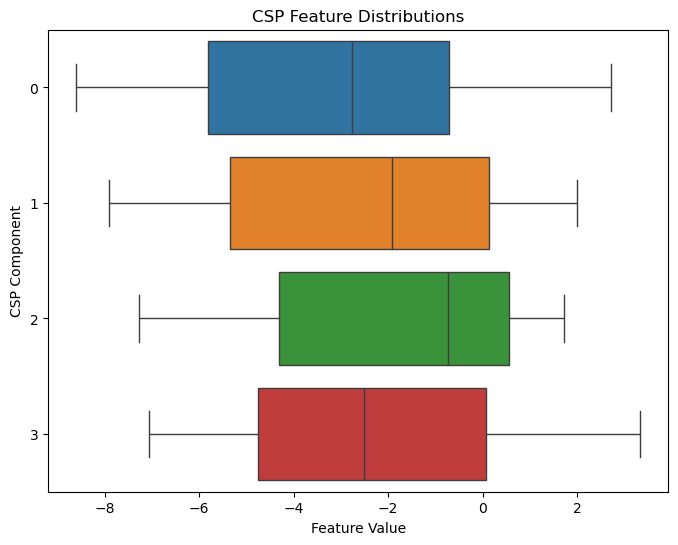

SVM Classification Accuracy per Fold: [0.95299145 0.95299145 0.95299145 0.92274678]
Average Accuracy: 0.9454
1043
1043
Computing rank from data with rank=None
    Using tolerance 6.3e+05 (2.2e-16 eps * 47 dim * 6e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 1


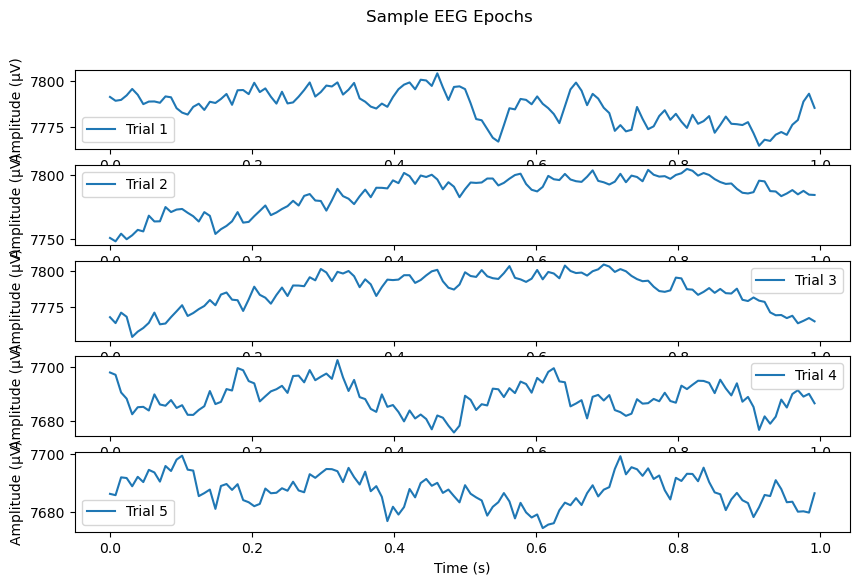

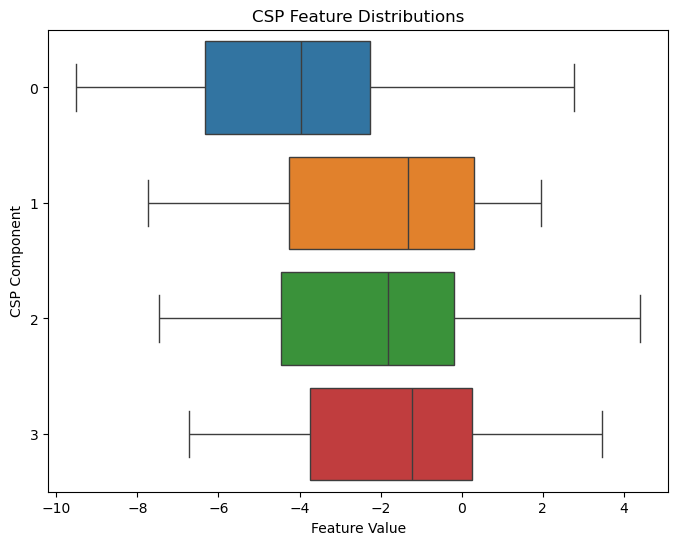

SVM Classification Accuracy per Fold: [0.95019157 0.9348659  0.9348659  0.95      ]
Average Accuracy: 0.9425
1282
1282
Computing rank from data with rank=None
    Using tolerance 5.4e+05 (2.2e-16 eps * 47 dim * 5.2e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 2


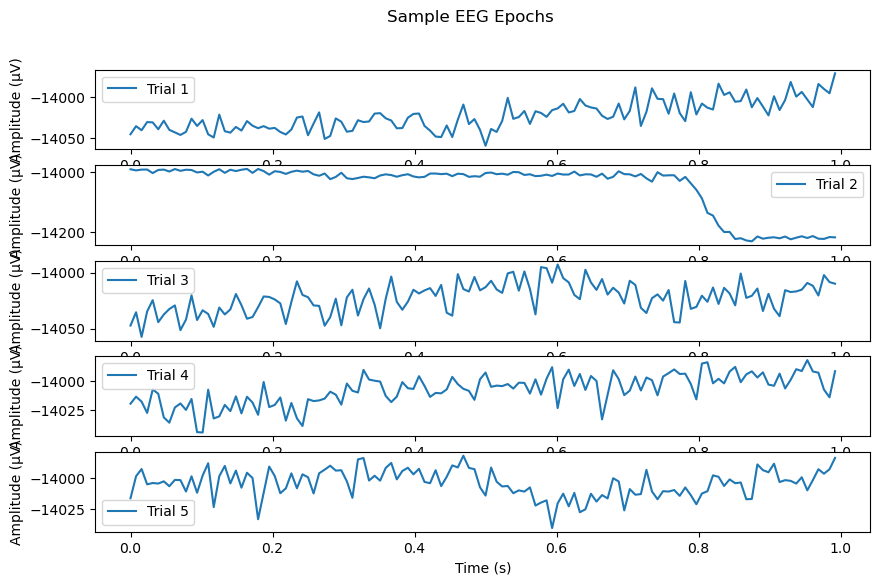

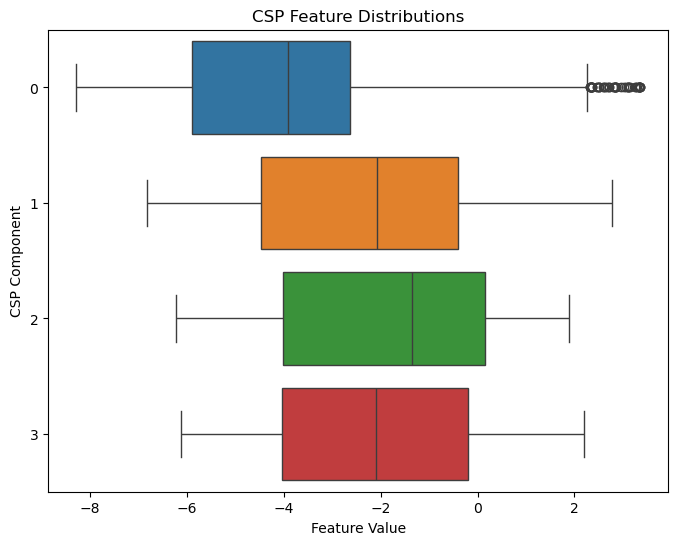

SVM Classification Accuracy per Fold: [0.95327103 0.95327103 0.95625    0.95625   ]
Average Accuracy: 0.9548
1116
1116
Computing rank from data with rank=None
    Using tolerance 8.3e+05 (2.2e-16 eps * 47 dim * 7.9e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 4


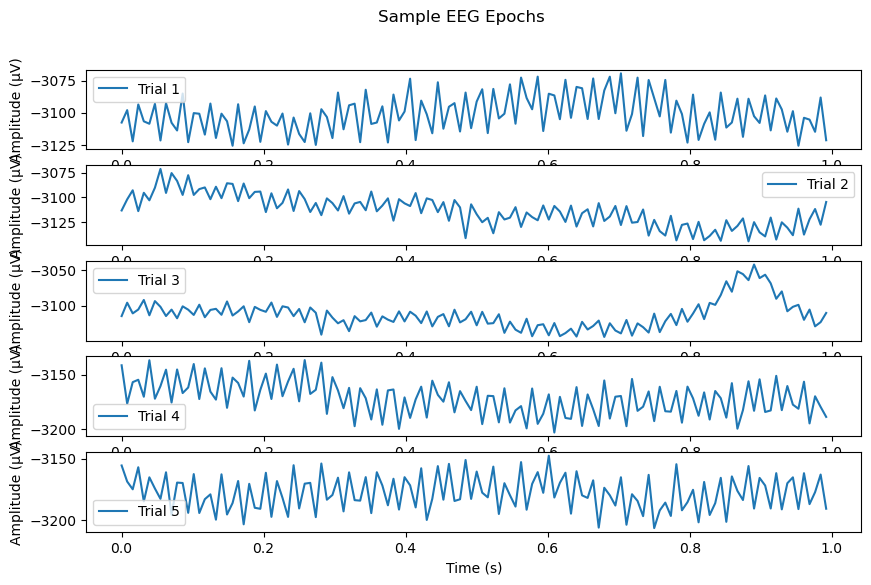

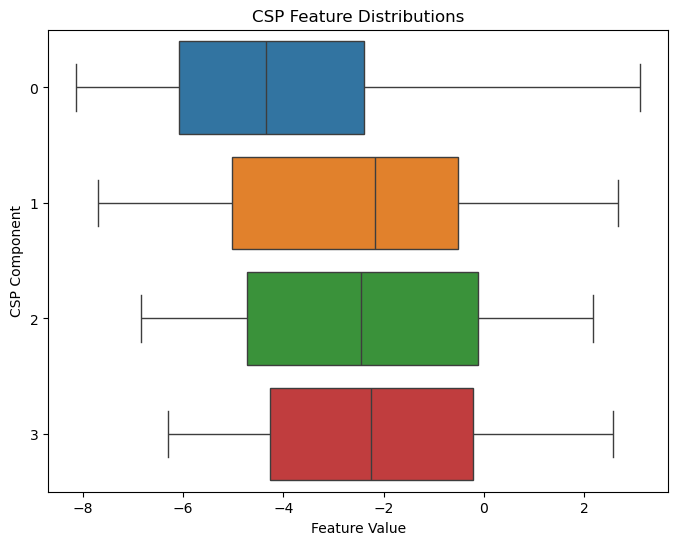

SVM Classification Accuracy per Fold: [0.94982079 0.94623656 0.94623656 0.94623656]
Average Accuracy: 0.9471
1132
1132
Computing rank from data with rank=None
    Using tolerance 4.5e+05 (2.2e-16 eps * 47 dim * 4.3e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 5


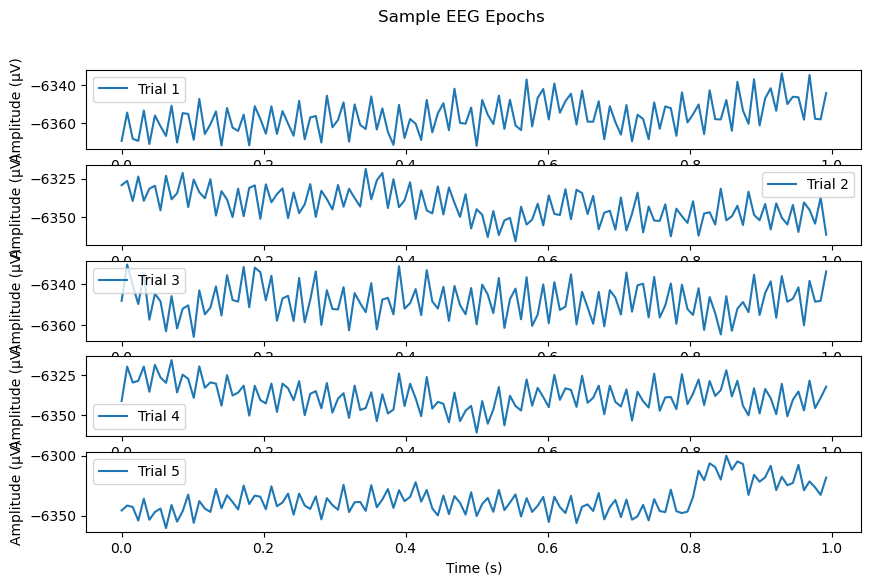

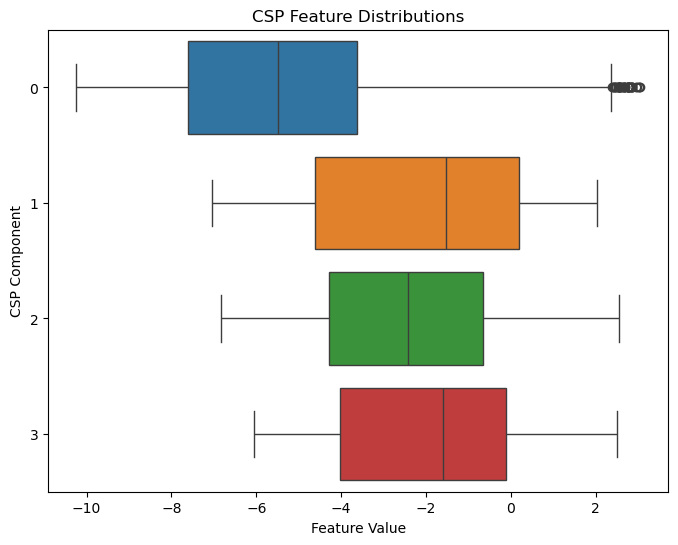

SVM Classification Accuracy per Fold: [0.96466431 0.96113074 0.92932862 0.96113074]
Average Accuracy: 0.9541
1115
1115
Computing rank from data with rank=None
    Using tolerance 5.6e+05 (2.2e-16 eps * 47 dim * 5.3e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 6


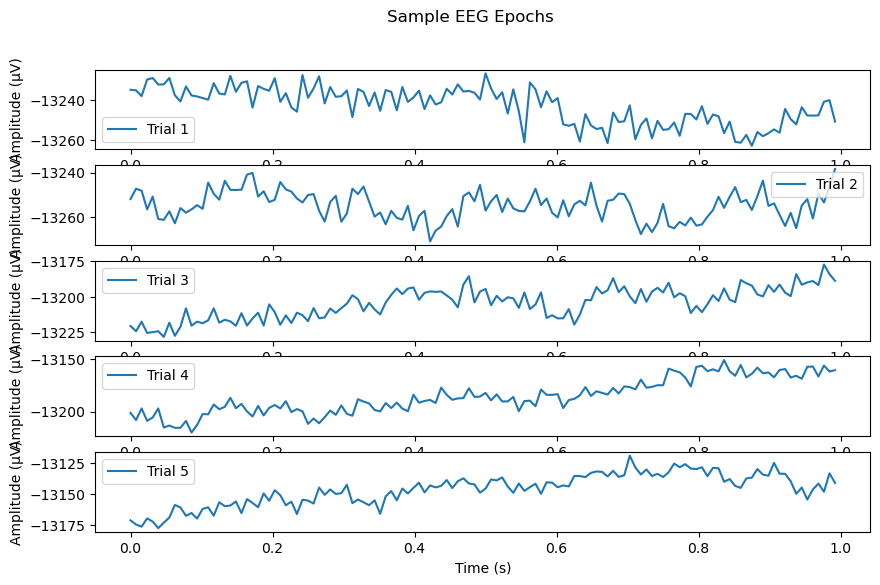

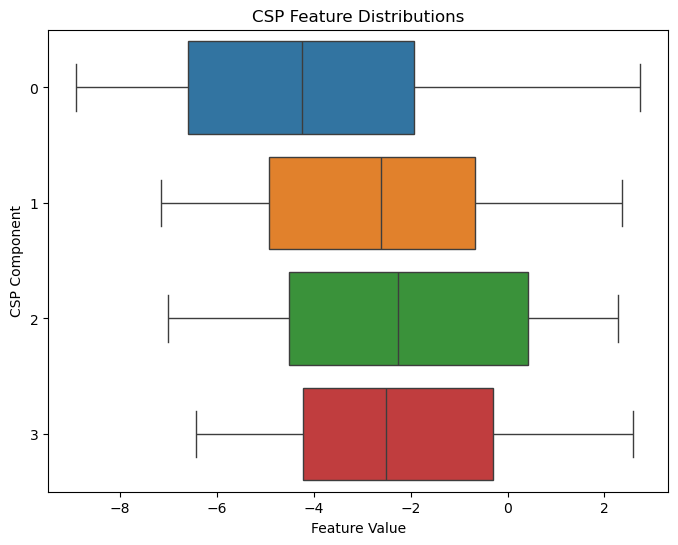

SVM Classification Accuracy per Fold: [0.94623656 0.94265233 0.94265233 0.94604317]
Average Accuracy: 0.9444
996
996
Computing rank from data with rank=None
    Using tolerance 5.8e+05 (2.2e-16 eps * 47 dim * 5.5e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 7


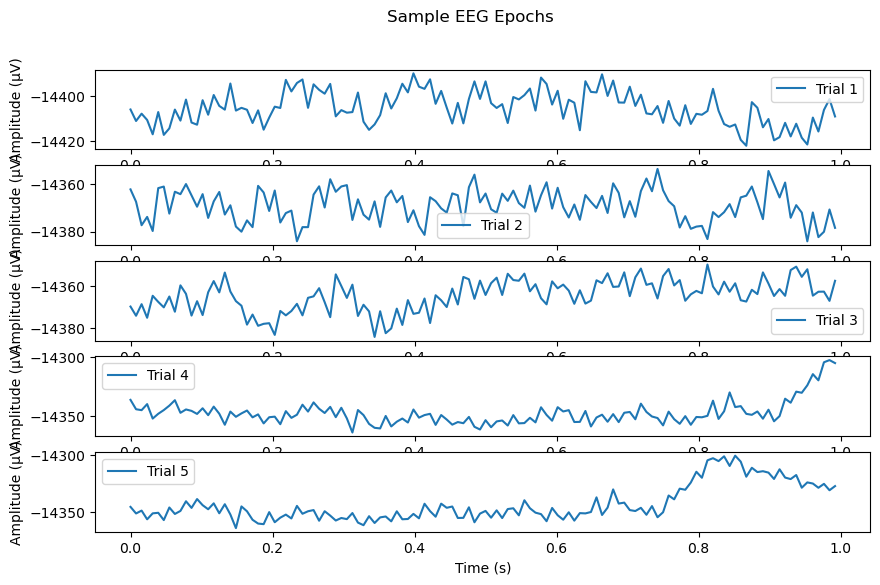

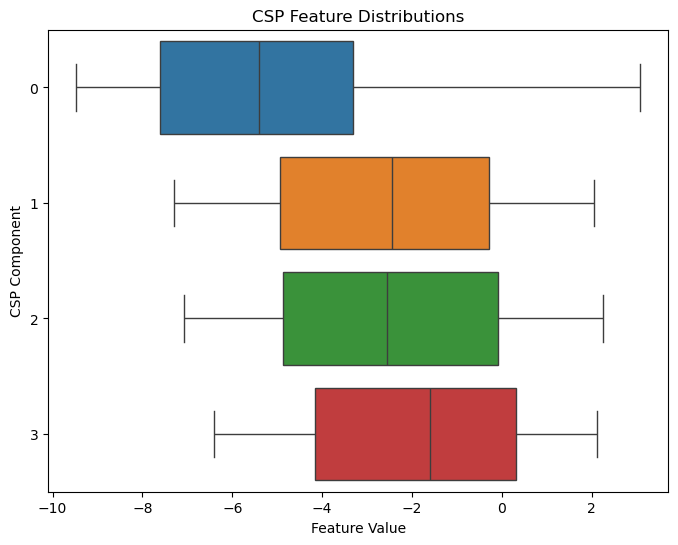

SVM Classification Accuracy per Fold: [0.9437751  0.9437751  0.88353414 0.9437751 ]
Average Accuracy: 0.9287
1134
1134
Computing rank from data with rank=None
    Using tolerance 6e+05 (2.2e-16 eps * 47 dim * 5.7e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 9


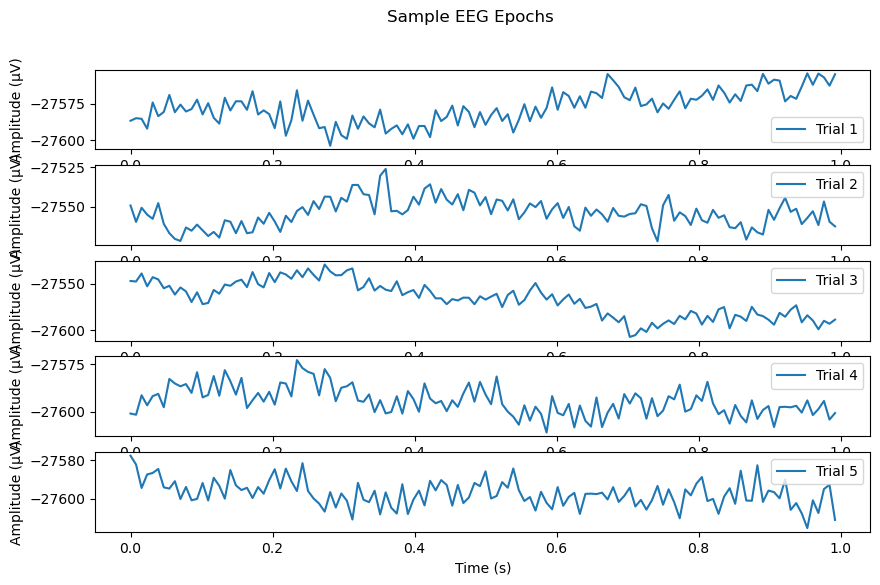

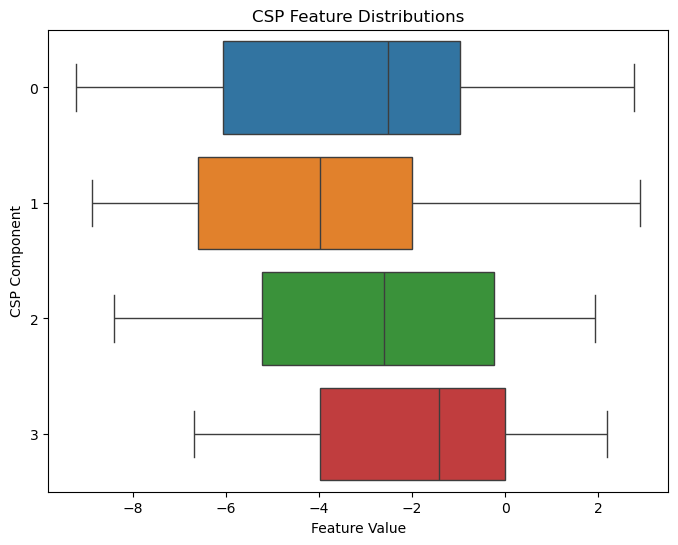

SVM Classification Accuracy per Fold: [0.94014085 0.94014085 0.95759717 0.9540636 ]
Average Accuracy: 0.9480
1040
1040
Computing rank from data with rank=None
    Using tolerance 5.7e+05 (2.2e-16 eps * 47 dim * 5.5e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 10


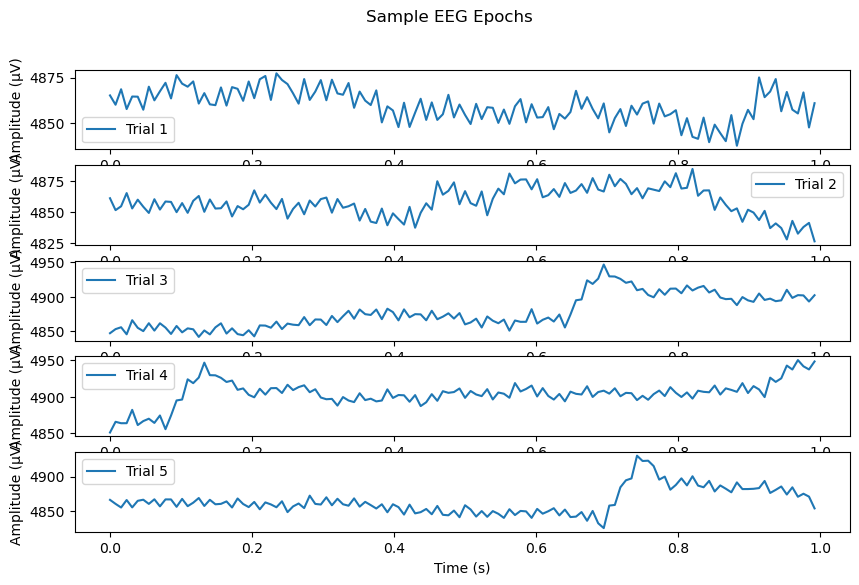

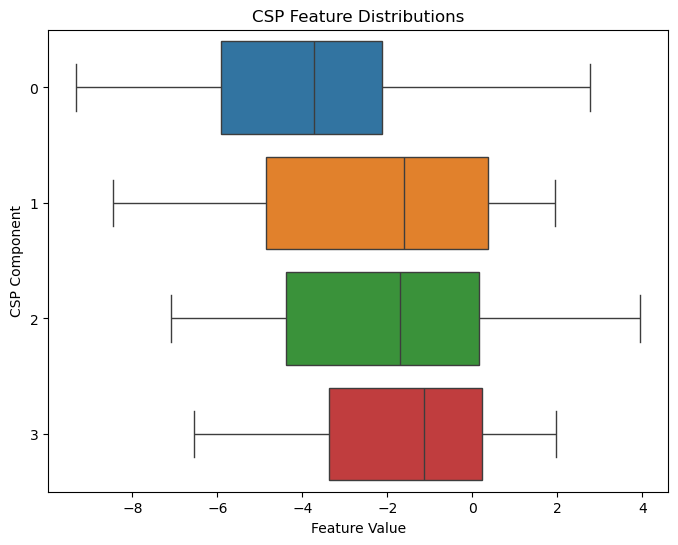

SVM Classification Accuracy per Fold: [0.97692308 0.97307692 0.95384615 0.93846154]
Average Accuracy: 0.9606
900
900
Computing rank from data with rank=None
    Using tolerance 6.6e+05 (2.2e-16 eps * 47 dim * 6.3e+19  max singular value)
    Estimated rank (data): 46
    data: rank 46 computed from 47 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 47 -> 46
Estimating class=False covariance using EMPIRICAL
Done.
Estimating class=True covariance using EMPIRICAL
Done.
Subject Number: 11


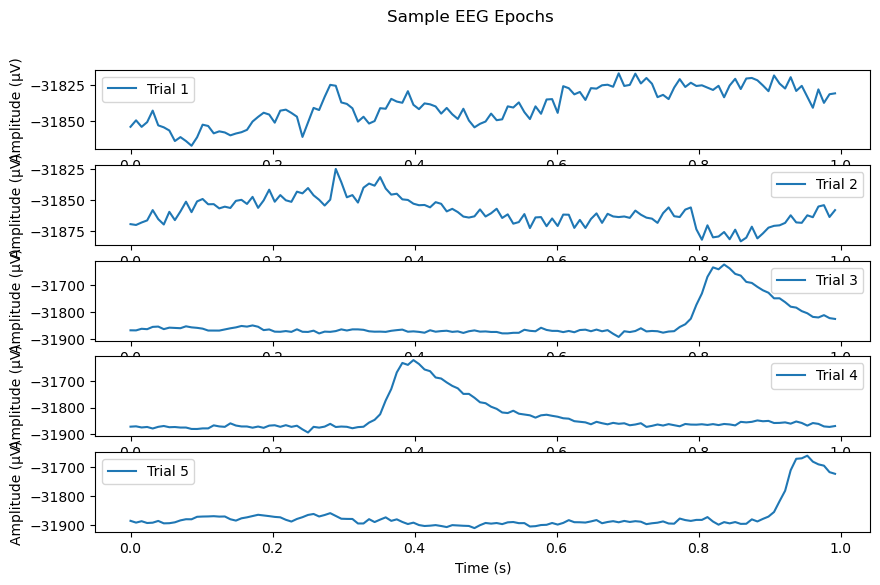

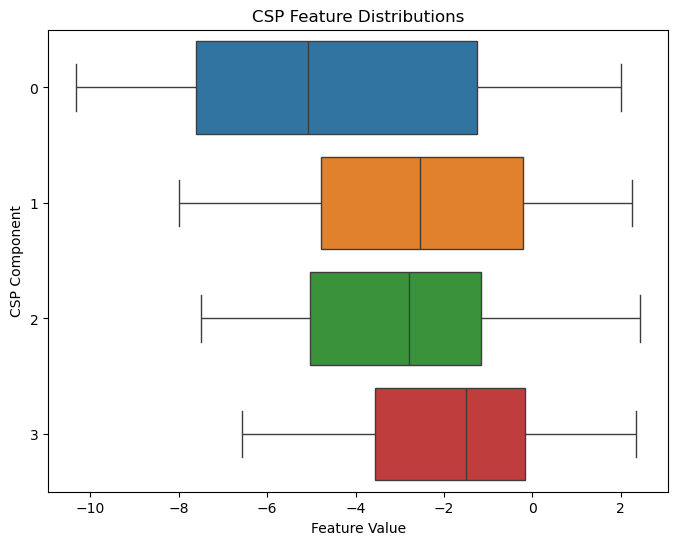

SVM Classification Accuracy per Fold: [0.95111111 0.84       0.97333333 0.96      ]
Average Accuracy: 0.9311


In [7]:
# right vs right error

# Parameters
n_filters = 4  # CSP components per class
k = 4  # Number of cross-validation folds

# Load data

for i in range(12): 
    if i in [3, 8]:
        continue
    rec = load(i)

    # Extract EEG data
    X = rec.X
    events = rec.events
    event_lab = rec.event_lab
    fs = int(1.0 / rec.dt[0]) # sampling rate

    right_press = 2
    right_error = 4

    selected_events = events[:, np.isin(events[0], [right_press, right_error])]

    # Epoch extraction
    window = int(fs * 1)  # 1-second window
    epochs = []
    labels = []
    for event, start_time in selected_events[:2].T:
        start_idx = int(start_time)
        end_idx = start_idx + window
        if end_idx < X.shape[1]:  # Ignore out-of-bounds epochs
            epochs.append(X[:, start_idx:end_idx])
            labels.append(event == right_error)
    
    X_epochs = np.array(epochs)  # Shape: (n_trials, n_channels, n_samples)

    # CSP
    csp = CSP(n_components=n_filters, log=True)
    X_epochs = X_epochs.astype(np.float64)
    print(len(X_epochs))
    print(len(labels))
    X_csp = csp.fit_transform(X_epochs, labels)
    
    # SVM classifier with cross-validation
    svm = SVC(kernel='linear')
    scores = cross_val_score(svm, X_csp, labels, cv=k)
    
    # Output results
    print(f'Subject Number: {i}')
    plot_epochs(X_epochs, fs)
    plot_csp_features(X_csp, labels)
    print(f'SVM Classification Accuracy per Fold: {scores}')
    print(f'Average Accuracy: {np.mean(scores):.4f}')